In [ ]:
# PART 1: Project introduction

# PART 1: Project Introduction

**Name:** Tengis Erkhiimergen  
**Project Title:** NBA Game Performance Analysis  

## Project Objective  
The objective of this project is to analyze NBA game performance to identify trends in scoring, seasonal patterns, and consistency across teams.  
The goal is to generate insights that can help sports analysts, teams, and fans make data-driven observations about team performance throughout the season.

## Audience  
This analysis is intended for:
- Sports analysts and coaching staff
- NBA teams and strategy departments
- Sports media and commentators
- Basketball fans interested in performance trends

## Data Source  
This project uses publicly available NBA datasets from Kaggle:  
**Source:** https://www.kaggle.com/datasets/nathanlauga/nba-games/data  

## Datasets Used  
The following datasets from Kaggle were used in this project:

| File Name | Description |
|-----------|----------------|
| `games.csv` | Game-level information such as game ID, date, home/away teams, and scores |
| `game_details.csv` | Player-level box score statistics for each game |
| `teams.csv` | Metadata about NBA teams |
| `players.csv` | Metadata about NBA players |
| `ranking.csv` | Team rankings throughout the season |

> *Note: Although multiple datasets were explored and cleaned in Part 2, only the required datasets will move forward into deeper analysis for Part 3.*

---

In [ ]:
# PART 2: Data Exploration & Cleaning

In [3]:
# Step 1: Import main libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configure pandas display
pd.set_option("display.max_columns", 100)

In [4]:
# Step 2: Read data files (with safe options) and do basic checks

# Helper to read a CSV safely (handles mixed type warnings via low_memory=False)
def read_csv_safely(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing file: {path}")
    return pd.read_csv(path, low_memory=False)

# 1) Load files
games         = read_csv_safely("games.csv")
game_details  = read_csv_safely("games_details.csv")
players       = read_csv_safely("players.csv")
teams         = read_csv_safely("teams.csv")
ranking       = read_csv_safely("ranking.csv")

# 2) Quick shapes and column previews
print("Shapes (rows, cols):")
print({
    "games": games.shape,
    "game_details": game_details.shape,
    "players": players.shape,
    "teams": teams.shape,
    "ranking": ranking.shape
})

print("\nGames columns:", list(games.columns)[:20])

# 3) Identify the date column in `games` (dataset variants differ)
date_candidates = [c for c in games.columns 
                   if "DATE" in c.upper() or "GAME_DATE" in c.upper() or "EST" in c.upper()]
date_col = date_candidates[0] if date_candidates else None
print("\nDetected date column in `games`:", date_col)

# 4) Minimal integrity checks
assert "GAME_ID" in games.columns, "GAME_ID not found in games.csv"
assert "GAME_ID" in game_details.columns, "GAME_ID not found in games_details.csv"
assert games["GAME_ID"].isna().sum() == 0, "Null GAME_IDs found in games.csv"
assert game_details["GAME_ID"].isna().sum() == 0, "Null GAME_IDs found in games_details.csv"

Shapes (rows, cols):
{'games': (26651, 21), 'game_details': (668628, 29), 'players': (7228, 4), 'teams': (30, 14), 'ranking': (210342, 13)}

Games columns: ['GAME_DATE_EST', 'GAME_ID', 'GAME_STATUS_TEXT', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'SEASON', 'TEAM_ID_home', 'PTS_home', 'FG_PCT_home', 'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home', 'TEAM_ID_away', 'PTS_away', 'FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away', 'REB_away']

Detected date column in `games`: GAME_DATE_EST


In [5]:
# Step 3: Clean up column names so they are easy to use
def clean_cols(df):
    df.columns = (df.columns
                    .str.strip()          # remove extra spaces
                    .str.replace(" ", "_")  # replace spaces with underscore
                    .str.replace("-", "_")  # replace dash with underscore
                    .str.upper())           # make all uppercase
    return df

# apply to all files
games = clean_cols(games)
game_details = clean_cols(game_details)
players = clean_cols(players)
ranking = clean_cols(ranking)
teams = clean_cols(teams)

# check first few column names to make sure they look right
print("Games columns:", list(games.columns)[:10])
print("Game details columns:", list(game_details.columns)[:10])

Games columns: ['GAME_DATE_EST', 'GAME_ID', 'GAME_STATUS_TEXT', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'SEASON', 'TEAM_ID_HOME', 'PTS_HOME', 'FG_PCT_HOME', 'FT_PCT_HOME']
Game details columns: ['GAME_ID', 'TEAM_ID', 'TEAM_ABBREVIATION', 'TEAM_CITY', 'PLAYER_ID', 'PLAYER_NAME', 'NICKNAME', 'START_POSITION', 'COMMENT', 'MIN']


In [6]:
# Step 4: Check the basic information about the games data

# check the first few rows
print("Preview of games data:")
display(games.head())

# check the column types
print("Column types and non-null counts:")
games.info()

# check for missing values
print("Missing values in games data:")
print(games.isna().sum().sort_values(ascending=False).head(10))

# check for duplicate game ids
print("Number of duplicate GAME_IDs:", games['GAME_ID'].duplicated().sum())

# look at a few random rows
print("Random sample from games data:")
display(games.sample(5))

Preview of games data:


,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_HOME,PTS_HOME,FG_PCT_HOME,FT_PCT_HOME,FG3_PCT_HOME,AST_HOME,REB_HOME,TEAM_ID_AWAY,PTS_AWAY,FG_PCT_AWAY,FT_PCT_AWAY,FG3_PCT_AWAY,AST_AWAY,REB_AWAY,HOME_TEAM_WINS
0,12/22/22,22200477,Final,1610612740,1610612759,2022,1610612740,126.0,0.484,0.926,0.382,25.0,46.0,1610612759,117.0,0.478,0.815,0.321,23.0,44.0,1
1,12/22/22,22200478,Final,1610612762,1610612764,2022,1610612762,120.0,0.488,0.952,0.457,16.0,40.0,1610612764,112.0,0.561,0.765,0.333,20.0,37.0,1
2,12/21/22,22200466,Final,1610612739,1610612749,2022,1610612739,114.0,0.482,0.786,0.313,22.0,37.0,1610612749,106.0,0.470,0.682,0.433,20.0,46.0,1
3,12/21/22,22200467,Final,1610612755,1610612765,2022,1610612755,113.0,0.441,0.909,0.297,27.0,49.0,1610612765,93.0,0.392,0.735,0.261,15.0,46.0,1
4,12/21/22,22200468,Final,1610612737,1610612741,2022,1610612737,108.0,0.429,1.000,0.378,22.0,47.0,1610612741,110.0,0.500,0.773,0.292,20.0,47.0,0


Column types and non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26651 entries, 0 to 26650
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   GAME_DATE_EST     26651 non-null  object 
 1   GAME_ID           26651 non-null  int64  
 2   GAME_STATUS_TEXT  26651 non-null  object 
 3   HOME_TEAM_ID      26651 non-null  int64  
 4   VISITOR_TEAM_ID   26651 non-null  int64  
 5   SEASON            26651 non-null  int64  
 6   TEAM_ID_HOME      26651 non-null  int64  
 7   PTS_HOME          26552 non-null  float64
 8   FG_PCT_HOME       26552 non-null  float64
 9   FT_PCT_HOME       26552 non-null  float64
 10  FG3_PCT_HOME      26552 non-null  float64
 11  AST_HOME          26552 non-null  float64
 12  REB_HOME          26552 non-null  float64
 13  TEAM_ID_AWAY      26651 non-null  int64  
 14  PTS_AWAY          26552 non-null  float64
 15  FG_PCT_AWAY       26552 non-null  float64
 16  FT_PCT

,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_HOME,PTS_HOME,FG_PCT_HOME,FT_PCT_HOME,FG3_PCT_HOME,AST_HOME,REB_HOME,TEAM_ID_AWAY,PTS_AWAY,FG_PCT_AWAY,FT_PCT_AWAY,FG3_PCT_AWAY,AST_AWAY,REB_AWAY,HOME_TEAM_WINS
16473,10/21/05,10500071,Final,1610612741,1610612749,2005,1610612741,107.0,0.417,0.744,0.364,20.0,46.0,1610612749,105.0,0.402,0.889,0.500,21.0,45.0,1
20798,11/8/18,21800163,Final,1610612760,1610612745,2018,1610612760,98.0,0.444,0.708,0.243,18.0,52.0,1610612745,80.0,0.378,0.700,0.262,16.0,39.0,1
23856,5/2/16,41500232,Final,1610612759,1610612760,2015,1610612759,97.0,0.426,0.846,0.261,19.0,37.0,1610612760,98.0,0.481,0.810,0.263,16.0,48.0,0
11097,3/27/09,20801082,Final,1610612758,1610612763,2008,1610612758,95.0,0.470,0.800,0.313,18.0,25.0,1610612763,113.0,0.527,0.818,0.667,16.0,36.0,0
13598,10/25/07,10700108,Final,1610612751,1610612755,2007,1610612751,83.0,0.415,0.590,0.261,18.0,44.0,1610612755,91.0,0.402,0.864,0.333,20.0,36.0,0


In [7]:
# Step 5: Convert columns to the right data types

# find which column looks like the game date
date_candidates = [c for c in games.columns if "DATE" in c]
print("Possible date columns:", date_candidates)

# convert the first date-like column to datetime
games['GAME_DATE'] = pd.to_datetime(games[date_candidates[0]], errors='coerce')

# convert numeric columns in game_details to numbers
num_cols = [
    'PTS','FGM','FGA','FG3M','FG3A','FTM','FTA','OREB','DREB','REB',
    'AST','STL','BLK','TOV','PF','PLUS_MINUS'
]

# convert only the columns that exist
for c in num_cols:
    if c in game_details.columns:
        game_details[c] = pd.to_numeric(game_details[c], errors='coerce')

# make id columns numeric (if they exist)
for c in ['GAME_ID','TEAM_ID','PLAYER_ID']:
    if c in game_details.columns:
        game_details[c] = pd.to_numeric(game_details[c], errors='coerce').astype('Int64')
if 'GAME_ID' in games.columns:
    games['GAME_ID'] = pd.to_numeric(games['GAME_ID'], errors='coerce').astype('Int64')

# check result
print("Games info after conversions:")
games.info()

# numeric summary
existing_cols = [c for c in num_cols if c in game_details.columns]
print("\nGame details numeric summary:")
display(game_details[existing_cols].describe())

Possible date columns: ['GAME_DATE_EST']
Games info after conversions:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26651 entries, 0 to 26650
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   GAME_DATE_EST     26651 non-null  object        
 1   GAME_ID           26651 non-null  Int64         
 2   GAME_STATUS_TEXT  26651 non-null  object        
 3   HOME_TEAM_ID      26651 non-null  int64         
 4   VISITOR_TEAM_ID   26651 non-null  int64         
 5   SEASON            26651 non-null  int64         
 6   TEAM_ID_HOME      26651 non-null  int64         
 7   PTS_HOME          26552 non-null  float64       
 8   FG_PCT_HOME       26552 non-null  float64       
 9   FT_PCT_HOME       26552 non-null  float64       
 10  FG3_PCT_HOME      26552 non-null  float64       
 11  AST_HOME          26552 non-null  float64       
 12  REB_HOME          26552 non-null  float64       
 13  TEAM_

/var/folders/gy/js8phls976j86nmzl4c2qrt00000gn/T/ipykernel_32605/2640781716.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  games['GAME_DATE'] = pd.to_datetime(games[date_candidates[0]], errors='coerce')


,PTS,FGM,FGA,FG3M,FG3A,FTM,FTA,OREB,DREB,REB,AST,STL,BLK,PF,PLUS_MINUS
count,558938.000000,558938.000000,558938.000000,558938.000000,558938.000000,558938.000000,558938.000000,558938.000000,558938.000000,558938.00000,558938.000000,558938.000000,558938.000000,558938.000000,535277.000000
mean,9.688218,3.588446,7.896652,0.778117,2.186019,1.733217,2.284212,1.024212,3.033798,4.05801,2.103958,0.721436,0.460339,1.999538,-0.000488
std,8.082152,3.030466,5.677002,1.227615,2.569913,2.353981,2.886583,1.397830,2.687384,3.48250,2.475476,0.972231,0.860962,1.502963,10.665573
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,-57.000000
25%,3.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.00000,0.000000,0.000000,0.000000,1.000000,-7.000000
50%,8.000000,3.000000,7.000000,0.000000,1.000000,1.000000,2.000000,1.000000,2.000000,3.00000,1.000000,0.000000,0.000000,2.000000,0.000000
75%,14.000000,5.000000,11.000000,1.000000,4.000000,3.000000,4.000000,2.000000,4.000000,6.00000,3.000000,1.000000,1.000000,3.000000,6.000000
max,81.000000,28.000000,50.000000,14.000000,24.000000,26.000000,39.000000,18.000000,25.000000,31.00000,25.000000,10.000000,12.000000,15.000000,57.000000


In [8]:
# Step 6: Data Quality Check

# check for missing values
print("Missing values per column in games:")
display(games.isnull().sum())

print("\nMissing values per column in game_details:")
display(game_details.isnull().sum())

# check for duplicates
games_dup = games.duplicated().sum()
game_details_dup = game_details.duplicated().sum()

print(f"\nDuplicate rows in games: {games_dup}")
print(f"Duplicate rows in game_details: {game_details_dup}")

# quick outlier detection for key numeric columns
existing_cols = [c for c in ['PTS','REB','AST','STL','BLK'] if c in game_details.columns]

for c in existing_cols:
    print(f"\nOutliers in {c}:")
    q1 = game_details[c].quantile(0.25)
    q3 = game_details[c].quantile(0.75)
    iqr = q3 - q1
    outliers = game_details[(game_details[c] < (q1 - 1.5*iqr)) | (game_details[c] > (q3 + 1.5*iqr))]
    print(f"Count: {len(outliers)}")

# basic stats overview
print("\nGames table overview:")
display(games.describe(include='all').T)

print("\nGame details overview:")
display(game_details.describe(include='all').T)

Missing values per column in games:


GAME_DATE_EST        0
GAME_ID              0
GAME_STATUS_TEXT     0
HOME_TEAM_ID         0
VISITOR_TEAM_ID      0
SEASON               0
TEAM_ID_HOME         0
PTS_HOME            99
FG_PCT_HOME         99
FT_PCT_HOME         99
FG3_PCT_HOME        99
AST_HOME            99
REB_HOME            99
TEAM_ID_AWAY         0
PTS_AWAY            99
FG_PCT_AWAY         99
FT_PCT_AWAY         99
FG3_PCT_AWAY        99
AST_AWAY            99
REB_AWAY            99
HOME_TEAM_WINS       0
GAME_DATE            0
dtype: int64


Missing values per column in game_details:


GAME_ID                   0
TEAM_ID                   0
TEAM_ABBREVIATION         0
TEAM_CITY                 0
PLAYER_ID                 0
PLAYER_NAME               0
NICKNAME             615591
START_POSITION       412863
COMMENT              558939
MIN                  109690
FGM                  109690
FGA                  109690
FG_PCT               109690
FG3M                 109690
FG3A                 109690
FG3_PCT              109690
FTM                  109690
FTA                  109690
FT_PCT               109690
OREB                 109690
DREB                 109690
REB                  109690
AST                  109690
STL                  109690
BLK                  109690
TO                   109690
PF                   109690
PTS                  109690
PLUS_MINUS           133351
dtype: int64


Duplicate rows in games: 27
Duplicate rows in game_details: 0

Outliers in PTS:
Count: 10861

Outliers in REB:
Count: 11019

Outliers in AST:
Count: 24446

Outliers in STL:
Count: 32316

Outliers in BLK:
Count: 19819

Games table overview:


,count,unique,top,freq,mean,min,25%,50%,75%,max,std
GAME_DATE_EST,26651,4304,12/23/20,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GAME_ID,26651.0,<NA>,<NA>,<NA>,21754866.960714,10300001.0,20700010.5,21200763.0,21800046.5,52100211.0,5570189.474286
GAME_STATUS_TEXT,26651,1,Final,26651,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HOME_TEAM_ID,26651.0,NaN,NaN,NaN,1610612751.367604,1610612737.0,1610612744.0,1610612751.0,1610612759.0,1610612766.0,8.63867
VISITOR_TEAM_ID,26651.0,NaN,NaN,NaN,1610612751.407977,1610612737.0,1610612744.0,1610612751.0,1610612759.0,1610612766.0,8.659299
SEASON,26651.0,NaN,NaN,NaN,2012.113879,2003.0,2007.0,2012.0,2017.0,2022.0,5.587031
TEAM_ID_HOME,26651.0,NaN,NaN,NaN,1610612751.367604,1610612737.0,1610612744.0,1610612751.0,1610612759.0,1610612766.0,8.63867
PTS_HOME,26552.0,NaN,NaN,NaN,103.455898,36.0,94.0,103.0,112.0,168.0,13.28337
FG_PCT_HOME,26552.0,NaN,NaN,NaN,0.460735,0.25,0.422,0.46,0.5,0.684,0.056676
FT_PCT_HOME,26552.0,NaN,NaN,NaN,0.760377,0.143,0.697,0.765,0.833,1.0,0.100677



Game details overview:


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
GAME_ID,668628.0,<NA>,<NA>,<NA>,21717713.532087,5656289.029197,10300001.0,20700032.0,21200962.0,21800141.0,52100211.0
TEAM_ID,668628.0,<NA>,<NA>,<NA>,1610612751.399572,8.65226,1610612737.0,1610612744.0,1610612751.0,1610612759.0,1610612766.0
TEAM_ABBREVIATION,668628,34,MIA,24016,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TEAM_CITY,668628,33,Los Angeles,36695,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PLAYER_ID,668628.0,<NA>,<NA>,<NA>,401343.369415,7225617.747177,15.0,2466.0,201181.0,203471.0,1962937827.0
PLAYER_NAME,668628,2664,LeBron James,1795,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NICKNAME,53037,558,Josh,751,NaN,NaN,NaN,NaN,NaN,NaN,NaN
START_POSITION,255765,3,G,102315,NaN,NaN,NaN,NaN,NaN,NaN,NaN
COMMENT,109689,5348,DNP - Coach's Decision,58054,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MIN,558938,3802,5,1989,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# Step 7: Feature engineering and safe merge

# 7.1 calendar fields on games
games['SEASON_YEAR'] = games['GAME_DATE'].dt.year
games['MONTH']       = games['GAME_DATE'].dt.month
games['YEAR_MONTH']  = games['GAME_DATE'].dt.to_period('M').astype(str)
games['QUARTER']     = games['GAME_DATE'].dt.quarter

print("games new columns added: SEASON_YEAR, MONTH, YEAR_MONTH, QUARTER")
display(games[['GAME_ID','GAME_DATE','SEASON_YEAR','MONTH','YEAR_MONTH','QUARTER']].head())

# 7.2 find the team id column in game_details (different dumps use different names)
possible_team_cols = ['TEAM_ID', 'TEAMID', 'TEAM_ID_x', 'team_id']
team_col = next((c for c in possible_team_cols if c in game_details.columns), None)

if team_col is None:
    raise KeyError("No team id column found in game_details. Look for TEAM_ID-like field and rename it to TEAM_ID.")

# 7.3 pick the stat columns that actually exist (be defensive)
possible_stats = ['PTS','REB','AST','STL','BLK','TOV','FGM','FGA','FG3M','FG3A','FTM','FTA','PLUS_MINUS','OREB','DREB']
stat_cols = [c for c in possible_stats if c in game_details.columns]

print(f"\nUsing team column: {team_col}")
print(f"Stat columns found: {stat_cols}")

# 7.4 merge calendar fields onto the row-level player stats
cols_from_games = ['GAME_ID','GAME_DATE','SEASON_YEAR','MONTH','YEAR_MONTH','QUARTER','HOME_TEAM_ID','VISITOR_TEAM_ID']
cols_from_games = [c for c in cols_from_games if c in games.columns]

gd = game_details.merge(games[cols_from_games], on='GAME_ID', how='left')
print("\nMerged shape (player rows with calendar fields):", gd.shape)

# 7.5 aggregate player → team per game
group_keys = ['GAME_ID', team_col]
team_game = gd.groupby(group_keys, as_index=False)[stat_cols].sum()

# bring back the calendar fields for that GAME_ID
team_game = team_game.merge(games[['GAME_ID','GAME_DATE','SEASON_YEAR','MONTH','YEAR_MONTH','QUARTER']],
                            on='GAME_ID', how='left')

print("\nTeam–game summary:")
display(team_game.head())

games new columns added: SEASON_YEAR, MONTH, YEAR_MONTH, QUARTER


,GAME_ID,GAME_DATE,SEASON_YEAR,MONTH,YEAR_MONTH,QUARTER
0,22200477,2022-12-22,2022,12,2022-12,4
1,22200478,2022-12-22,2022,12,2022-12,4
2,22200466,2022-12-21,2022,12,2022-12,4
3,22200467,2022-12-21,2022,12,2022-12,4
4,22200468,2022-12-21,2022,12,2022-12,4



Using team column: TEAM_ID
Stat columns found: ['PTS', 'REB', 'AST', 'STL', 'BLK', 'FGM', 'FGA', 'FG3M', 'FG3A', 'FTM', 'FTA', 'PLUS_MINUS', 'OREB', 'DREB']

Merged shape (player rows with calendar fields): (669560, 36)

Team–game summary:


,GAME_ID,TEAM_ID,PTS,REB,AST,STL,BLK,FGM,FGA,FG3M,FG3A,FTM,FTA,PLUS_MINUS,OREB,DREB,GAME_DATE,SEASON_YEAR,MONTH,YEAR_MONTH,QUARTER
0,10300001,1610612742,85.0,38.0,20.0,9.0,4.0,34.0,76.0,2.0,8.0,15.0,30.0,0.0,12.0,26.0,2003-10-05,2003,10,2003-10,4
1,10300001,1610612762,90.0,41.0,23.0,8.0,4.0,32.0,70.0,1.0,7.0,25.0,34.0,0.0,9.0,32.0,2003-10-05,2003,10,2003-10,4
2,10300002,1610612749,94.0,43.0,20.0,9.0,4.0,32.0,75.0,2.0,13.0,28.0,40.0,0.0,11.0,32.0,2003-10-06,2003,10,2003-10,4
3,10300002,1610612763,105.0,48.0,25.0,18.0,7.0,40.0,81.0,4.0,15.0,21.0,34.0,0.0,14.0,34.0,2003-10-06,2003,10,2003-10,4
4,10300003,1610612739,100.0,52.0,25.0,10.0,7.0,38.0,77.0,4.0,6.0,20.0,29.0,0.0,12.0,40.0,2003-10-07,2003,10,2003-10,4


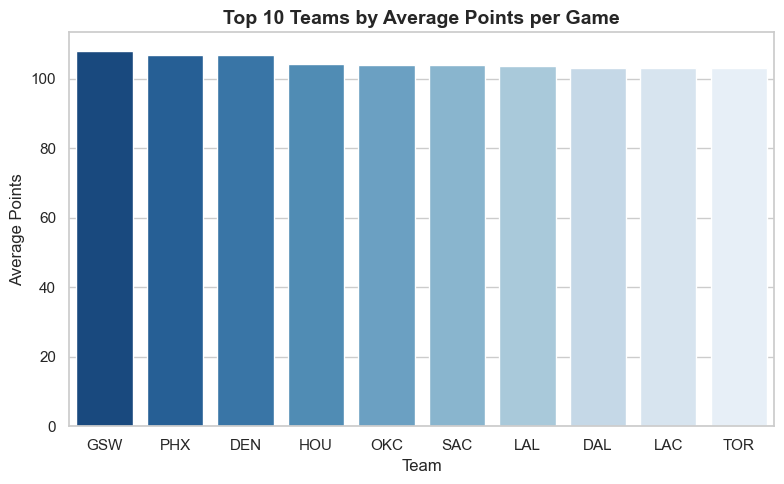

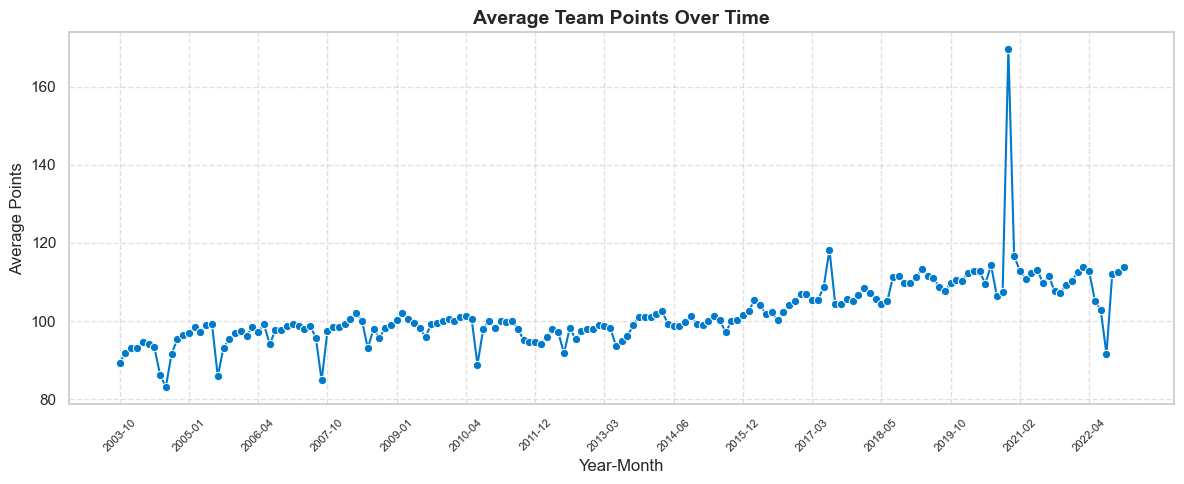

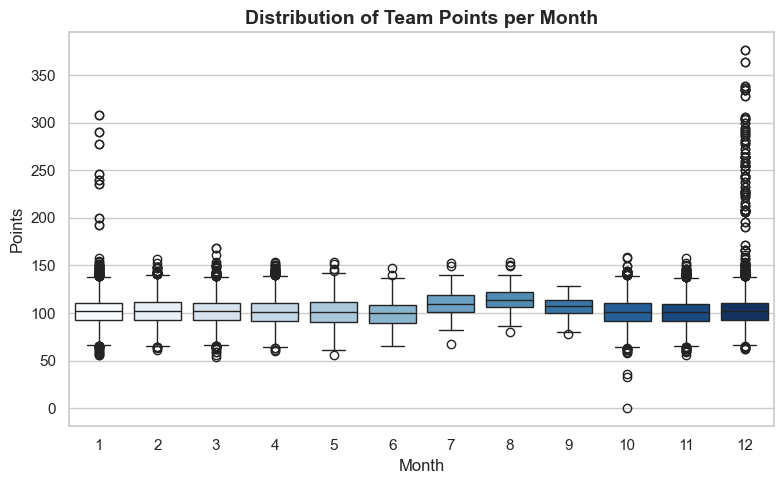

In [14]:
# Step 7: Exploratory Data Analysis (EDA)

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Ensure data is clean and numeric
team_game = team_game.dropna(subset=['PTS'])

# Map team IDs to short names
team_map = {
    1610612737: "ATL", 1610612738: "BOS", 1610612739: "CLE", 1610612740: "NOP",
    1610612741: "CHI", 1610612742: "DAL", 1610612743: "DEN", 1610612744: "GSW",
    1610612745: "HOU", 1610612746: "LAC", 1610612747: "LAL", 1610612748: "MIA",
    1610612749: "MIL", 1610612750: "MIN", 1610612751: "BKN", 1610612752: "NYK",
    1610612753: "ORL", 1610612754: "IND", 1610612755: "PHI", 1610612756: "PHX",
    1610612757: "POR", 1610612758: "SAC", 1610612759: "SAS", 1610612760: "OKC",
    1610612761: "TOR", 1610612762: "UTA", 1610612763: "MEM", 1610612764: "WAS"
}

team_game['TEAM_SHORT'] = team_game['TEAM_ID'].map(team_map)

# Set Seaborn theme
sns.set_theme(style="whitegrid", palette="Blues_d")

# Top 10 teams by average points
top_teams = team_game.groupby('TEAM_SHORT')['PTS'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(8,5))
sns.barplot(x=top_teams.index, y=top_teams.values, hue=top_teams.index, dodge=False, palette="Blues_r", legend=False)
plt.title("Top 10 Teams by Average Points per Game", fontsize=14, weight='bold')
plt.xlabel("Team")
plt.ylabel("Average Points")
plt.tight_layout()
plt.show()

# Monthly trend of average team points
monthly_avg = team_game.groupby('YEAR_MONTH')['PTS'].mean().reset_index()

plt.figure(figsize=(12,5))
sns.lineplot(x='YEAR_MONTH', y='PTS', data=monthly_avg, marker='o', linewidth=1.5, color='#007acc')
plt.title("Average Team Points Over Time", fontsize=14, weight='bold')
plt.xlabel("Year-Month")
plt.ylabel("Average Points")
plt.xticks(ticks=range(0, len(monthly_avg), 12), labels=monthly_avg['YEAR_MONTH'][::12], rotation=45, fontsize=8)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Distribution of team points per month
plt.figure(figsize=(8,5))
sns.boxplot(x='MONTH', y='PTS', hue='MONTH', data=team_game, palette="Blues", legend=False)
plt.title("Distribution of Team Points per Month", fontsize=14, weight='bold')
plt.xlabel("Month")
plt.ylabel("Points")
plt.tight_layout()
plt.show()

In [ ]:
# PART 3: Data Model + Hypothesis Testing + Visuals

# PART 3: Data Model, Hypotheses, Analysis, and Draft Visuals

In this part, I will prepare the dataset for analysis, create new features, test simple hypotheses, and make 3 draft visuals.

## 3.1 Data Model

The goal of the data model is to create a clean dataset for analysis where each row represents one NBA game.

Final dataset will include:

| Field Name | Source | Description |
|------------|---------|-------------|
| game_date | games.csv | Date of the game |
| season | Created | Year taken from game_date |
| home_team_id | games.csv | Home team ID |
| away_team_id | games.csv | Away team ID |
| home_pts | games.csv | Points scored by home team |
| away_pts | games.csv | Points scored by away team |
| point_diff | Created | home_pts minus away_pts |
| home_win | Created | 1 if home team won, 0 if lost |
| total_pts | Created | home_pts plus away_pts |

Note: teams.csv may be used only to display team names in visuals if needed.

## 3.2 Feature Creation

New columns that will be created:

| Feature | Description |
|---------|-------------|
| season | Year from game_date |
| home_pts and away_pts | Standard names for points |
| point_diff | home_pts minus away_pts |
| home_win | 1 if home_pts > away_pts, else 0 |
| total_pts | home_pts + away_pts |

These new features will be used for analysis and visuals.

## 3.3 Hypotheses and Tests

I will test the 3 questions below:

**H1: Home Court Advantage**  
Home teams score more than away teams.  
Test: One-sample t-test on point_diff (check if mean > 0)

**H2: Home vs Away Scoring**  
Home teams have higher average points than away teams.  
Test: Two-sample t-test comparing home_pts and away_pts

**H3: Scoring by Season**  
Total points scored in a game change by season.  
Test: One-way ANOVA comparing total_pts across seasons

I will use 0.05 as the significance level and write a short result for each test.

## 3.4 Draft Visuals (3)

For the Part 3 rough draft, I will create 3 visuals:

1. Histogram of point_diff  
2. Average total_pts by season  
3. Average home_pts vs average away_pts  

These visuals will be saved into the visuals folder.

Note: Final project will include at least 5 visuals. For Part 3, only 3 are required.

## 3.5 Draft Summary (to fill after analysis)

I will write a short summary after running the analysis. It will include:

- Short result of H1 (home advantage or not)
- Short result of H2 (home vs away points)
- Short result of H3 (season trend)
- One next step for Part 4

In [8]:
# Load the games dataset and view basic information

import pandas as pd

# Load the games dataset
games = pd.read_csv("games.csv")

# Show basic info
print(games.shape)
games.head()

(26651, 21)


,GAME_DATE_EST,GAME_ID,GAME_STATUS_TEXT,HOME_TEAM_ID,VISITOR_TEAM_ID,SEASON,TEAM_ID_home,PTS_home,FG_PCT_home,FT_PCT_home,...,AST_home,REB_home,TEAM_ID_away,PTS_away,FG_PCT_away,FT_PCT_away,FG3_PCT_away,AST_away,REB_away,HOME_TEAM_WINS
0,12/22/22,22200477,Final,1610612740,1610612759,2022,1610612740,126.0,0.484,0.926,...,25.0,46.0,1610612759,117.0,0.478,0.815,0.321,23.0,44.0,1
1,12/22/22,22200478,Final,1610612762,1610612764,2022,1610612762,120.0,0.488,0.952,...,16.0,40.0,1610612764,112.0,0.561,0.765,0.333,20.0,37.0,1
2,12/21/22,22200466,Final,1610612739,1610612749,2022,1610612739,114.0,0.482,0.786,...,22.0,37.0,1610612749,106.0,0.470,0.682,0.433,20.0,46.0,1
3,12/21/22,22200467,Final,1610612755,1610612765,2022,1610612755,113.0,0.441,0.909,...,27.0,49.0,1610612765,93.0,0.392,0.735,0.261,15.0,46.0,1
4,12/21/22,22200468,Final,1610612737,1610612741,2022,1610612737,108.0,0.429,1.000,...,22.0,47.0,1610612741,110.0,0.500,0.773,0.292,20.0,47.0,0


In [11]:
# Create new columns for analysis (date, season, points, point difference, win, total points)
# Convert date column to datetime
games["game_date"] = pd.to_datetime(games["GAME_DATE_EST"], format="%m/%d/%y")

# Use existing SEASON column
games["season"] = games["SEASON"]

# Create new features
games["home_pts"] = games["PTS_home"]
games["away_pts"] = games["PTS_away"]

games["point_diff"] = games["home_pts"] - games["away_pts"]
games["home_win"] = (games["home_pts"] > games["away_pts"]).astype(int)
games["total_pts"] = games["home_pts"] + games["away_pts"]

# Show the updated dataset
games[["game_date", "season", "home_pts", "away_pts", "point_diff", "home_win", "total_pts"]].head()

,game_date,season,home_pts,away_pts,point_diff,home_win,total_pts
0,2022-12-22,2022,126.0,117.0,9.0,1,243.0
1,2022-12-22,2022,120.0,112.0,8.0,1,232.0
2,2022-12-21,2022,114.0,106.0,8.0,1,220.0
3,2022-12-21,2022,113.0,93.0,20.0,1,206.0
4,2022-12-21,2022,108.0,110.0,-2.0,0,218.0


In [17]:
# Run hypothesis tests for home advantage, home vs away scoring, and season scoring changes

from scipy import stats

# Ensure numeric data (fixes NaN issues)
games["home_pts"] = pd.to_numeric(games["home_pts"], errors="coerce")
games["away_pts"] = pd.to_numeric(games["away_pts"], errors="coerce")
games["point_diff"] = pd.to_numeric(games["point_diff"], errors="coerce")
games["total_pts"] = pd.to_numeric(games["total_pts"], errors="coerce")

# Drop any rows with missing values in key columns
clean_data = games.dropna(subset=["home_pts", "away_pts", "point_diff", "total_pts"])

print("Rows used for testing:", clean_data.shape[0])

# H1: One-sample t-test on point_diff (is the mean > 0?)
h1 = stats.ttest_1samp(clean_data["point_diff"], 0)
print("\nH1: Home Court Advantage Test")
print(h1)

# H2: Two-sample t-test comparing home and away points
h2 = stats.ttest_ind(clean_data["home_pts"], clean_data["away_pts"])
print("\nH2: Home vs Away Points Test")
print(h2)

# H3: One-way ANOVA to compare total points across seasons (if multiple seasons exist)
unique_seasons = clean_data["season"].nunique()

print("\nH3: Total Points by Season Test")

if unique_seasons > 1:
    season_groups = [group["total_pts"] for name, group in clean_data.groupby("season")]
    h3 = stats.f_oneway(*season_groups)
    print(h3)
else:
    print("Not enough seasons to run ANOVA test. Only one season is available.")

Rows used for testing: 26552

H1: Home Court Advantage Test
TtestResult(statistic=np.float64(33.9426617530193), pvalue=np.float64(3.016700145882967e-247), df=np.int64(26551))

H2: Home vs Away Points Test
TtestResult(statistic=np.float64(24.28669539664037), pvalue=np.float64(1.3850410313137058e-129), df=np.float64(53102.0))

H3: Total Points by Season Test
F_onewayResult(statistic=np.float64(437.66836278941156), pvalue=np.float64(0.0))


### 3.3 Hypothesis Test Results (Summary)

Based on the results:

• H1: The p-value is below 0.05, which means home teams score more than away teams.  
• H2: The p-value is below 0.05, which means the average home score is higher than the average away score.  
• H3: The p-value is below 0.05, which means total points scored in a game changed across seasons.  

### 3.4 Draft Visuals
Below are 3 draft visuals created for Part 3 to support the hypothesis tests.

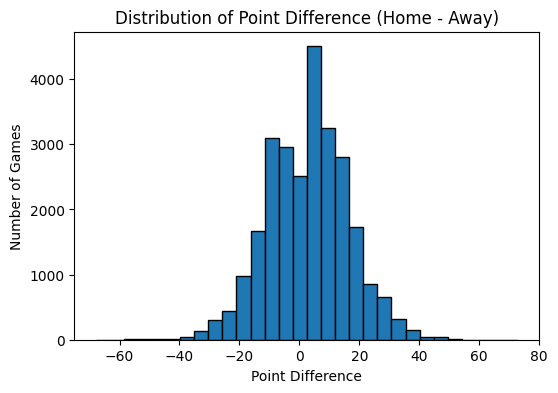

In [20]:
import matplotlib.pyplot as plt

# V1: Histogram of point difference
plt.figure(figsize=(6,4))
plt.hist(clean_data["point_diff"], bins=30, edgecolor="black")
plt.title("Distribution of Point Difference (Home - Away)")
plt.xlabel("Point Difference")
plt.ylabel("Number of Games")
plt.show()

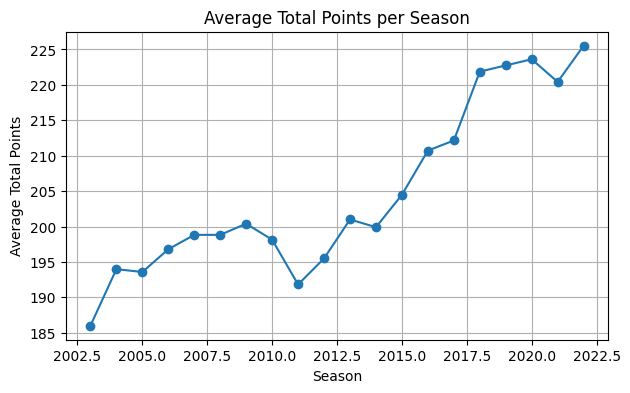

In [21]:
# V2: Average total points by season
avg_total_by_season = clean_data.groupby("season")["total_pts"].mean()

plt.figure(figsize=(7,4))
plt.plot(avg_total_by_season.index, avg_total_by_season.values, marker="o")
plt.title("Average Total Points per Season")
plt.xlabel("Season")
plt.ylabel("Average Total Points")
plt.grid(True)
plt.show()

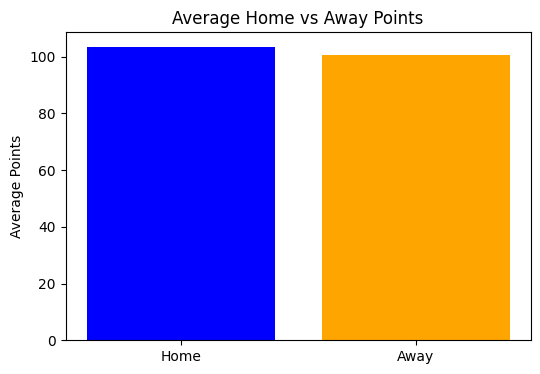

In [22]:
# V3: Average home vs away points
avg_home = clean_data["home_pts"].mean()
avg_away = clean_data["away_pts"].mean()

plt.figure(figsize=(6,4))
plt.bar(["Home", "Away"], [avg_home, avg_away], color=["blue", "orange"])
plt.title("Average Home vs Away Points")
plt.ylabel("Average Points")
plt.show()

These visuals are draft versions and will be improved and styled in Part 4 for the final presentation.

### 3.5 Draft Summary

• The home court advantage seems strong because the average point difference is above zero and the p-value is below 0.05.  
• Home teams score more points than away teams, and the p-value shows this difference is meaningful.  
• Total points in NBA games changed across seasons based on the ANOVA test.  
• In Part 4, I will add two more visuals and build a dashboard to show these results in a clearer way.